# Ch.7

NOTE: In this chapter We use geographical data, which requires some domain-specific packages related to the geographical information systems (GIS). I use **geopandas**, **libpysal** and **cartopy** packages. In some cases, The latter requreis some external C++ libraries. For example, If you use Ubuntu os, you can install it by:

```sh
apt install libgeos-dev libgeos++-dev
```

See the [official document](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing) in detail.

NOTE: **Plotnine** has `geom_polygon()` function too. However, currently (v0.8) plotnine provides `geom_map()`, which feature is not equal to either `geom_map()` or `geom_polygon` but `geom_sf` in **ggplot2**  (>3.0.0). `geom_map()` is convenient for `geopandas.DataFrame` objects because you don't need to specify longitude/lattitude and `group` variables, you need to only prepare the object which contains proper `geometry` column. So the following all examples, I used `geom_map` instead of `geom_polygon`. 

In [1]:
# minimal imports
import pandas as pd
import geopandas as gp
import numpy as np
from plotnine import *
import plotnine.options as p9options

# for graphical enhancement
from mizani.formatters import date_format, percent_format, dollar_format, comma_format
from mizani.palettes import brewer_pal
from pysocviz.p9extra import theme_map_pseudo

# In most cases, you may not import them.
# you may need them If only you are adhere to color tweaking...
from pysocviz.properties import dcolors

# This function is used for only Fig. 7.14 and 7.15.
from pysocviz.utils import statebins

p9options.figure_size = (6.4, 5.8)
theme_set(theme_minimal(base_family='Noto Sans CJK JP'))

# For figure 7.5
from cartopy import crs as ccrs 

In [2]:
from pysocviz.loader import load_dataset

election = load_dataset('election')

import libpysal  # >= 4.5.1

election = load_dataset('election')
county_map = load_dataset('county_map')
county_data = load_dataset('county_data')
opiates = load_dataset('opiates')

## Fig. 7.2

NOTE 1: In the online version, the data displyas "Democrat" but the correct label is "Democratic" in the dataset.

NOTE 2: No words for manual color mapping

In [3]:
party_colors = ["#2E74C0", "#CB454A"] # Democratic - Republican
party_colors = dict(zip(np.sort(election['party'].unique()), party_colors))

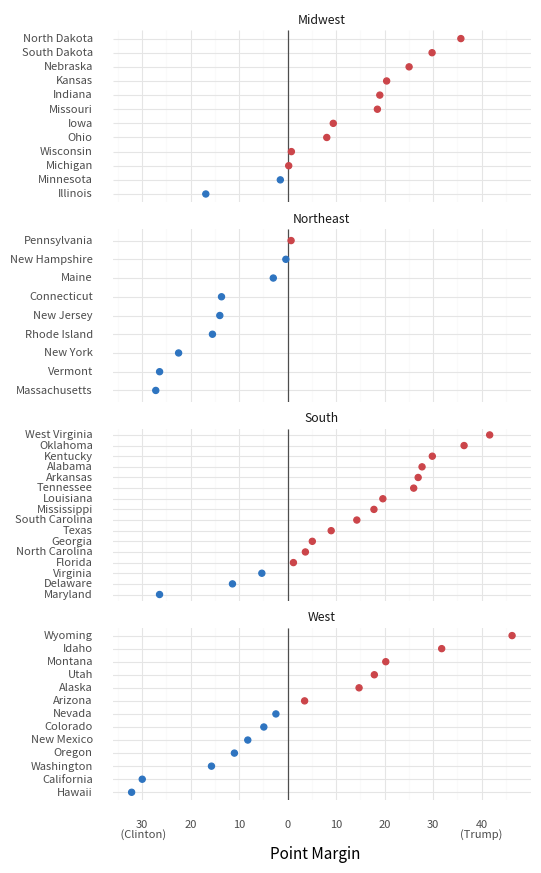

<ggplot: (8756709257244)>

In [4]:
p0 = ggplot(
    election.loc[lambda d: ~d['st'].isin(['DC'])],
    aes(x='r_points', y='reorder(state, r_points)', color='party')
)
p1 = p0 + geom_vline(xintercept=0, color=dcolors['gray30']
) + geom_point(size=2)
p2 = p1 + scale_color_manual(values=party_colors)
p3 = p2 + scale_x_continuous(
    breaks = [-30, -20, -10, 0, 10, 20, 30, 40],
    labels = ["30\n (Clinton)", "20", "10", "0",
               "10", "20", "30", "40\n(Trump)"]
)

p3 + facet_wrap('~ census', ncol=1, scales='free_y') + guides(
    color=False) + labs(x="Point Margin", y="") + theme(
    axis_text=element_text(size=8), figure_size=(5.4, 10))

## Fig. 7.3

NOTE 1: In this example, I import the US geo data from **libpysal** package. **libpysal** is used only for import the datasets whole this materials. 

In [5]:
# dataset information
libpysal.examples.explain('us_income')

us_income

Per-capita income for the lower 48 US states 1929-2009
------------------------------------------------------

* spi_download.csv: regional per capita income time series 1969-2008. (source:  Regional Economic Information System, Bureau of Economic Analysis, U.S. Department of Commerce) 
* states48.gal: contiguity weights in GAL format.
* us48.dbf: attribute data. (k=8)
* us48.shp: Polygon shapefile. (n=48) 
* us48.shx: spatial index.
* usjoin.csv: 48 US states per capita income time series 1929-2009.



In [6]:
# read SHP file from libpysal
us_states = gp.read_file(libpysal.examples.get_path('us48.shp'))
us_states = us_states.set_crs('EPSG:4326')

# to adjust to imitate the R dataset
us_states = us_states.rename(columns={c: c.lower() for c in us_states.columns})
us_states = us_states.rename(
    columns={'state_name': 'region', 'sub_region': 'subregion'})
us_states = us_states.drop(
    ['area', 'state_', 'perimeter', 'state_id', 'state_fips'], 1)
us_states = us_states.assign(region=lambda d: d['region'].str.lower())
us_states.head()

,region,subregion,state_abbr,geometry
0,washington,Pacific,WA,"MULTIPOLYGON (((-122.40075 48.22540, -122.4615..."
1,montana,Mtn,MT,"POLYGON ((-111.47463 44.70224, -111.48001 44.6..."
2,maine,N Eng,ME,"MULTIPOLYGON (((-69.77779 44.07407, -69.86044 ..."
3,north dakota,W N Cen,ND,"POLYGON ((-98.73006 45.93830, -99.00645 45.939..."
4,south dakota,W N Cen,SD,"POLYGON ((-102.78793 42.99532, -103.00541 42.9..."


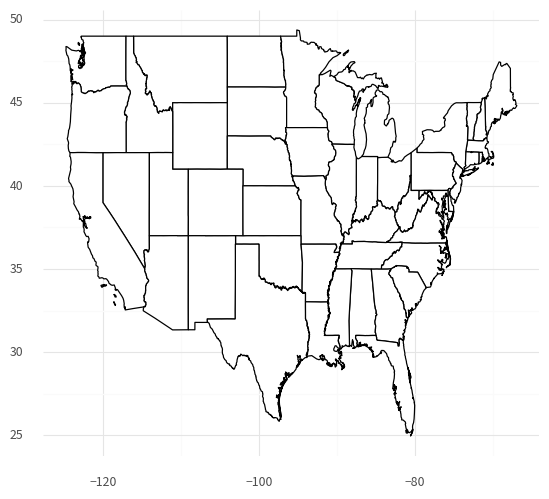

<ggplot: (8756709278242)>

In [7]:
ggplot(us_states) + geom_map(fill='white', color='black')

## Fig. 7.4

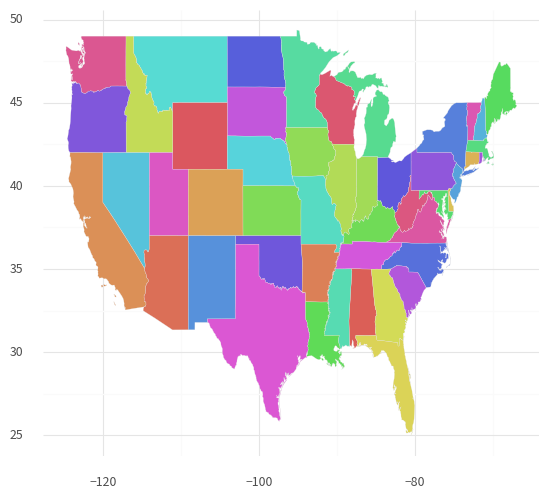

<ggplot: (8756708833064)>

In [8]:
p = ggplot(
    us_states,
    aes(fill='region')
)
p + geom_map(
    color=dcolors['gray90'], size=0.1
) + guides(fill=False)

## Fig. 7.5

NOTE: Currently (v0.8) plotnine doesn't support Albers or other geometric projections (but maybe possible in furture:  https://github.com/has2k1/plotnine/issues/14). If you want to do, consider to use geopandas and cartopy packages.

https://geopandas.org/gallery/cartopy_convert.html

remember that After the transformation, the dataset coordinates doesn't follow the orthogonal coordinate system; i.e. the scale of x/y axes are not actual coordiates

At first, I demonstrate how to convert projection. At first, set default CRS

In [9]:
us_states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

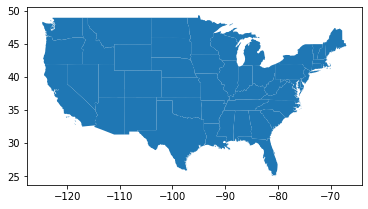

In [10]:
us_states.plot()

Then, I change it to the Albers projection.

/tmp/ipykernel_310449/2785240289.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_310449/2785240289.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



<AxesSubplot:>

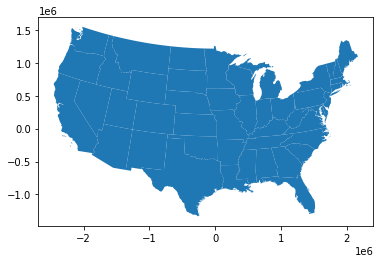

In [11]:
from cartopy import crs as ccrs
crs_Albers = ccrs.AlbersEqualArea(
    central_longitude=(us_states.centroid.to_crs('EPSG:4326').x.min() + us_states.centroid.to_crs('EPSG:4326').x.max())/2,
    central_latitude=(us_states.centroid.to_crs('EPSG:4326').y.min() + us_states.centroid.to_crs('EPSG:4326').y.max())/2,
    standard_parallels=(39, 45))
crs_proj4 = crs_Albers.proj4_init
us_states = us_states.to_crs(crs_proj4)
us_states.plot()

NOTE: We cannot change the grid line to Albers projection.

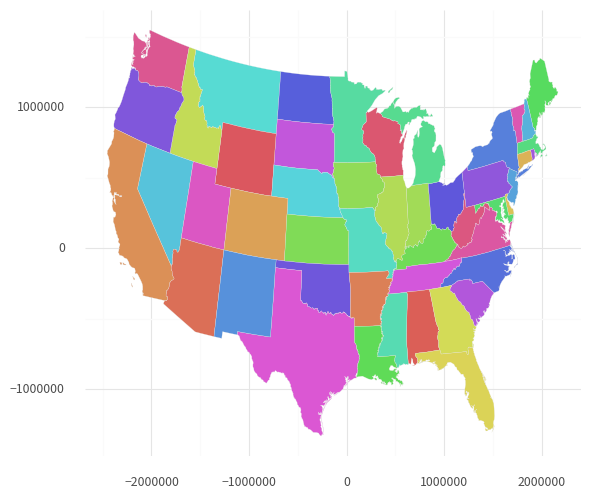

<ggplot: (8756696303719)>

In [12]:
# If you input this dataset, the shape is same but lon/lat labels are incorrect.
p = ggplot(
    us_states,
    aes(fill='region')
)
p + geom_map(
    color=dcolors['gray90'], size=0.1
) + guides(fill=False)

## Fig. 7.6

In [13]:
election = election.assign(region=lambda d: d['state'].str.lower())
us_states_elec = us_states.merge(election, on='region', how='left')

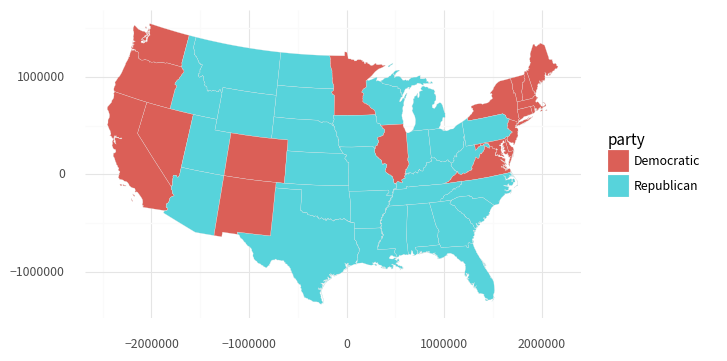

<ggplot: (8756696234108)>

In [14]:
p = ggplot(us_states_elec, aes(fill='party'))
p + geom_map(color=dcolors['gray90'], size=0.1) + coord_fixed()

## Fig. 7.7

NOTE: **plotnine** currently (v0.8) doesn't suuport `theme_map`. So in this case I manually set themeables to imitate this theme function. You can import this by `from pysocviz.p9extra import theme_map_pseudo`

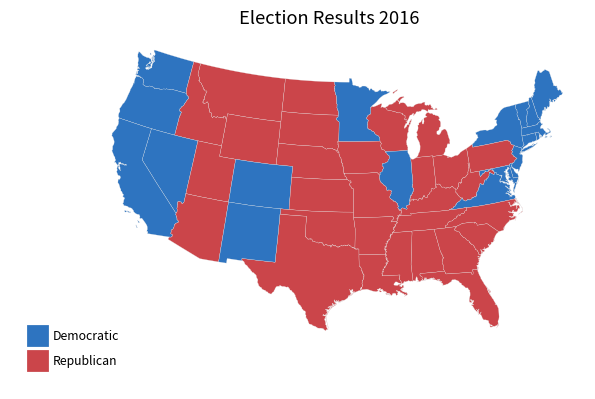

<ggplot: (8756709280594)>

In [15]:
p0 = ggplot(us_states_elec, aes(fill='party'))
p1 = p0 + geom_map(color=dcolors['gray90'], size=0.1) 
p2 = p1 + scale_fill_manual(values=party_colors) + labs(
    title="Election Results 2016")

p2 + theme_map_pseudo() + coord_fixed()

## Fig. 7.8

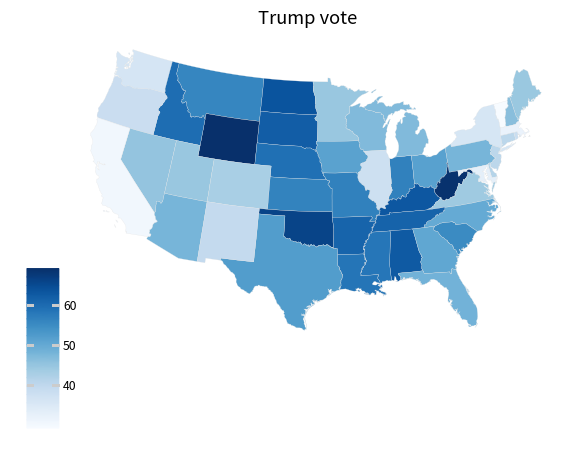

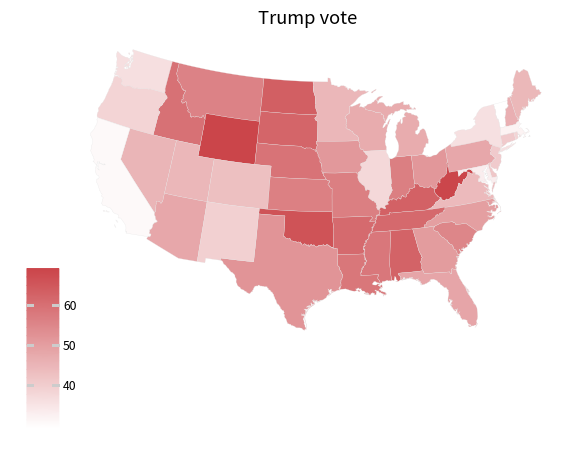

In [16]:
p0 = ggplot(us_states_elec, aes(fill='pct_trump'))

p1 = p0 + geom_map(color=dcolors['gray90'], size=0.1)

(
    p1 + labs(title="Trump vote") + theme_map_pseudo(
    ) + labs(fill="Percent") + scale_fill_cmap('Blues')  + coord_fixed()
).draw();

p2 = p1 + scale_fill_gradient(
    low="white", high="#CB454A") + labs(title = "Trump vote")
(
    p2 + theme_map_pseudo() + labs(fill = "Percent") + coord_fixed()
).draw();

## Fig. 7.9

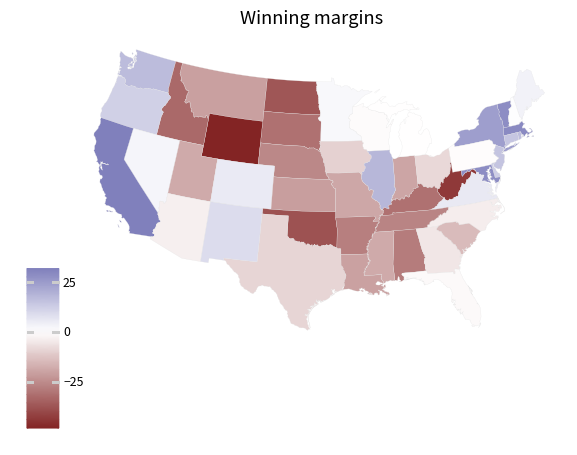

<ggplot: (8756696184245)>

In [17]:
p0 = ggplot(us_states_elec, aes(fill='d_points'))

p1 = p0 + geom_map(color=dcolors['gray90'], size=0.1) + coord_fixed() 

p2 = p1 + scale_fill_gradient2() + labs(title = "Winning margins") 
p2 + theme_map_pseudo() + labs(fill = "Percent")

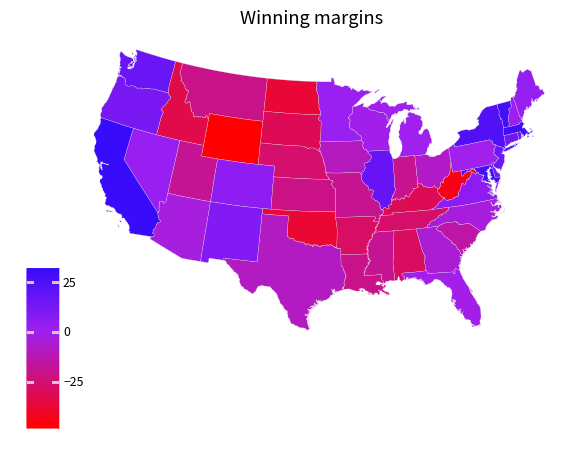

<ggplot: (8756696242532)>

In [18]:
p3 = p1 + scale_fill_gradient2(
    low="red", mid=dcolors['purple'], high="blue",
    breaks = [-25, 0, 25, 50, 75]
) + labs(title="Winning margins") 
p3 + theme_map_pseudo() + labs(fill = "Percent")

## Fig. 7.10

NOTE: Different from the R dataset, the dataset from libpysal doesn't contains the District of Columbia.

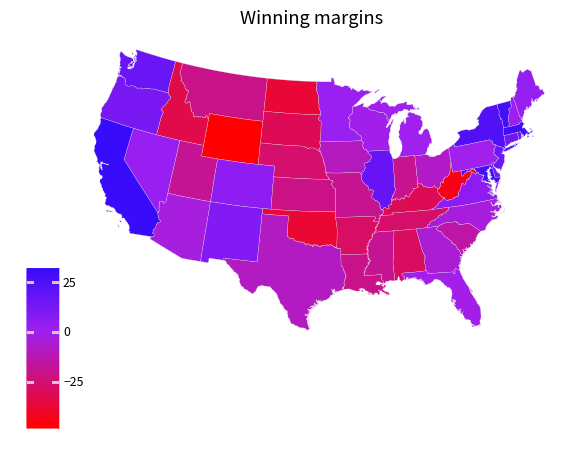

<ggplot: (8756696090402)>

In [19]:
p0 = ggplot(
    us_states_elec.loc[lambda d: ~d['region'].isin(['district of columbia'])],
    aes(fill='d_points')
)

p1 = p0 + geom_map(color=dcolors['gray90'], size=0.1) + coord_fixed()

p2 = p1 + scale_fill_gradient2(
    low = "red", mid=dcolors['purple'], high = "blue"
) + labs(title="Winning margins") 
p2 + theme_map_pseudo() + labs(fill="Percent")

## Fig. 7.11 

NOTE 1: Each row of `county_map` contains the vertex coordinates of polygons, so I used `geom_polygon` in the following examples.

NOTE 2: The `long`/`lat` columns of the dataset `country_map` doesn't correspond to the actual longitude/lattitude.

In [20]:
county_full = county_map.merge(county_data, on='id', how='left')

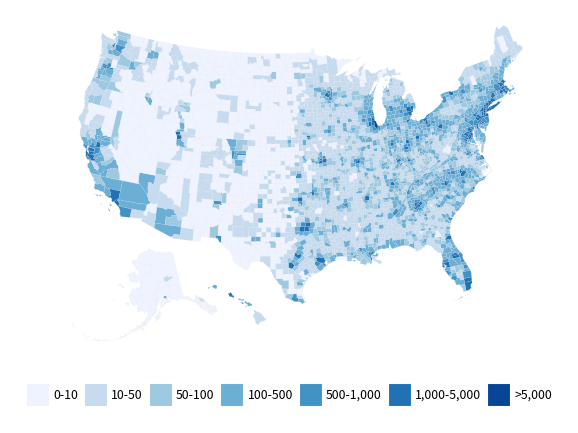

<ggplot: (8756695947846)>

In [21]:
p = ggplot(
    county_full,
    aes(x='long', y='lat', fill='pop_dens',  group='group')
)

p1 = p + geom_polygon(color=dcolors['gray90'], size=0.05) + coord_equal()

p2 = p1 + scale_fill_brewer(
    palette="Blues",
    labels=["0-10", "10-50", "50-100", "100-500", "500-1,000", "1,000-5,000", ">5,000"]
)

p2 + labs(fill="Population per\nsquare mile") + theme_map_pseudo(
) + guides(fill=guide_legend(nrow=1)) +  theme(legend_position="bottom")

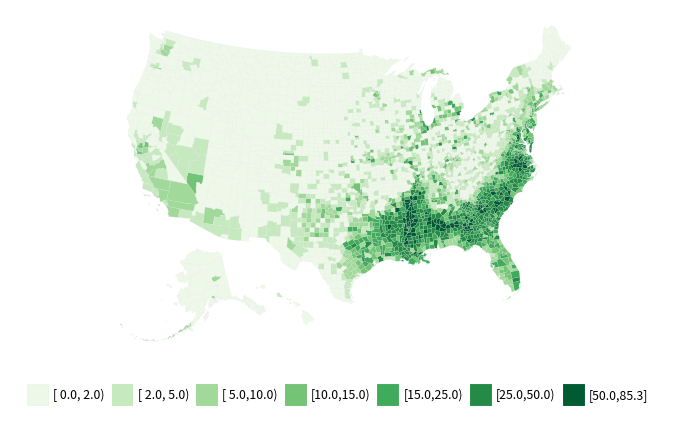

<ggplot: (8756709082299)>

In [22]:
p = ggplot(
    county_full,
    aes(x='long', y='lat', fill='pct_black', group='group')
)
p1 = p + geom_polygon(color=dcolors['gray90'], size=0.05) + coord_equal()
p2 = p1 + scale_fill_brewer(palette="Greens")
p2 + labs(fill="US Population, Percent Black") + guides(
    fill=guide_legend(nrow=1)
) + theme_map_pseudo() + theme(legend_position="bottom")

## Fig. 7.13

NOTE 1: **plotnine** currently (v0.8) support reversion of the color mapping by `direction=-1`. So you don't need to create a color palette manually to reverse it.

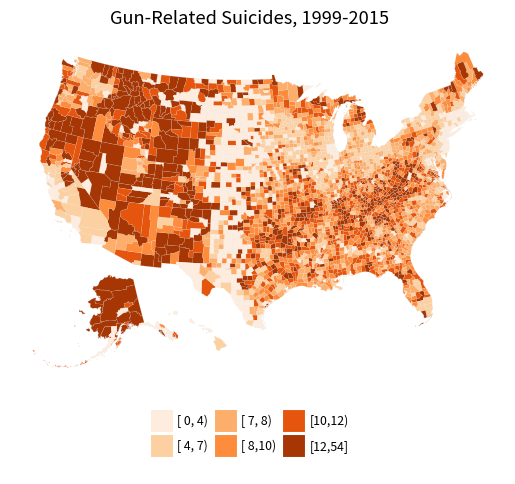

<ggplot: (8756690548447)>

In [23]:
gun_p = ggplot(
    county_full,
    aes(x='long', y='lat', fill='su_gun6', group='group')
)

gun_p1 = gun_p + geom_polygon(
    color=dcolors['gray90'], size=0.05) + coord_equal()

gun_p2 = gun_p1 + scale_fill_brewer(palette="Oranges")
gun_p2 + labs(
    title="Gun-Related Suicides, 1999-2015",
    fill="Rate per 100,000 pop."
) + theme_map_pseudo() + theme(legend_position="bottom")

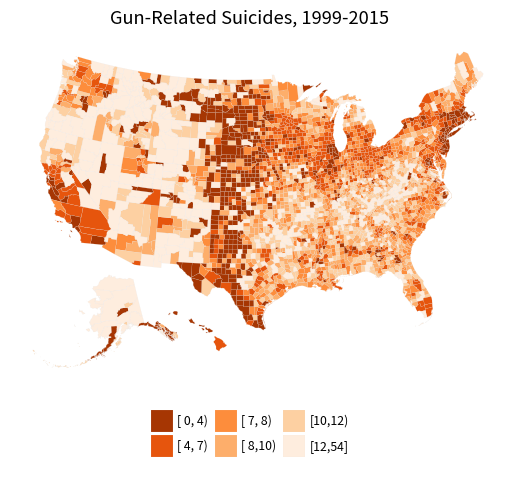

<ggplot: (8756689974769)>

In [24]:
gun_p = ggplot(
    county_full,
    aes(x='long', y='lat', fill='su_gun6', group='group')
)

gun_p1 = gun_p + geom_polygon(
    color=dcolors['gray90'], size=0.05) + coord_equal()

gun_p2 = gun_p1 + scale_fill_brewer(palette="Oranges", direction=-1)
gun_p2 + labs(
    title="Gun-Related Suicides, 1999-2015",
    fill="Rate per 100,000 pop."
) + theme_map_pseudo() + theme(legend_position="bottom")

If you want to imitate the original code, you can again use `brewer_pal()`.

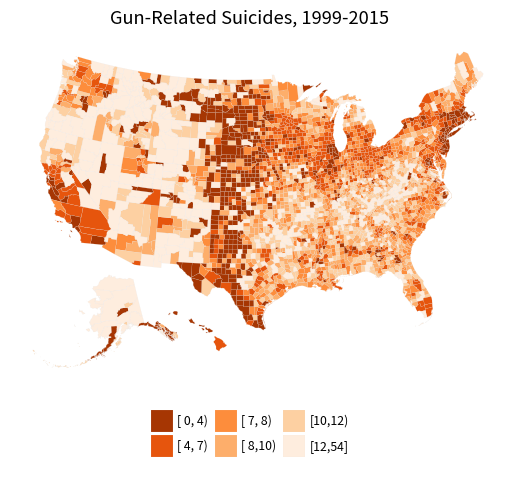

<ggplot: (8756696231750)>

In [25]:
orange_pal = brewer_pal('sequential', "Oranges", -1)(6)

gun_p1 + scale_fill_manual(orange_pal) + labs(
    title="Gun-Related Suicides, 1999-2015",
    fill="Rate per 100,000 pop."
) + theme_map_pseudo() + theme(legend_position="bottom")

## Fig. 7.14

NOTE: As usual, there is no package like **statebins** package in Python. Some users may make python script, but is is not seem to be general-porpose. So I created a minimal function. You can import it by `from pysocviz.utils import statebins`. Unlike the original function, it has few arguments on themes and color mappings. You need to add **plotnine** functions manually.

merged by abbreviations


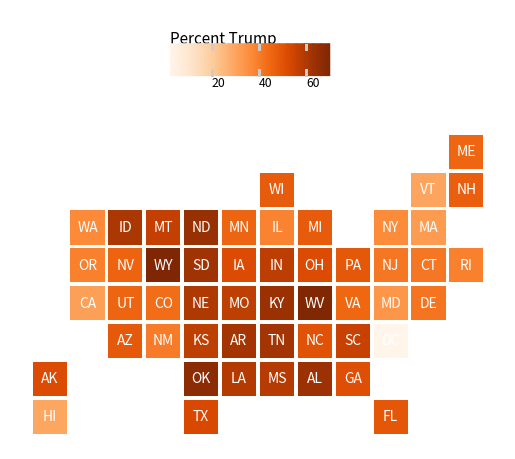

<ggplot: (8756689598492)>

In [26]:
statebins(
    election,
    state_col='st', value_col='pct_trump', text_color='white'
) + scale_fill_cmap('Oranges', name='Percent Trump'
) + theme(legend_title=element_text(), legend_position='top')

merged by abbreviations


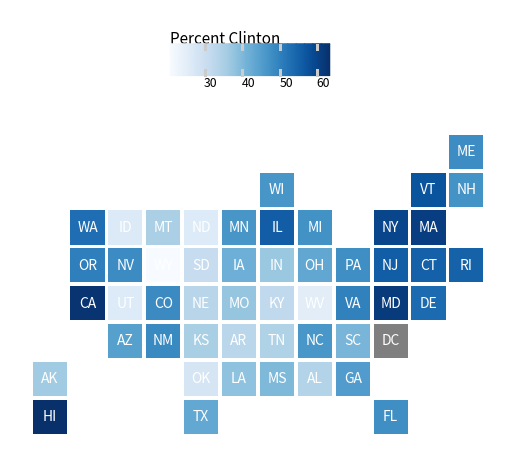

<ggplot: (8756691549543)>

In [27]:
statebins(
    election.loc[lambda d: d['st']!='DC'],
    state_col='st', value_col='pct_clinton', text_color='white'
) + scale_fill_cmap('Blues', name='Percent Clinton'
) + theme(legend_title=element_text(), legend_position='top')

## Fig. 7.15

NOTE: You can use `pd.cut()` to easily discretize numeric variables.

merged by state names


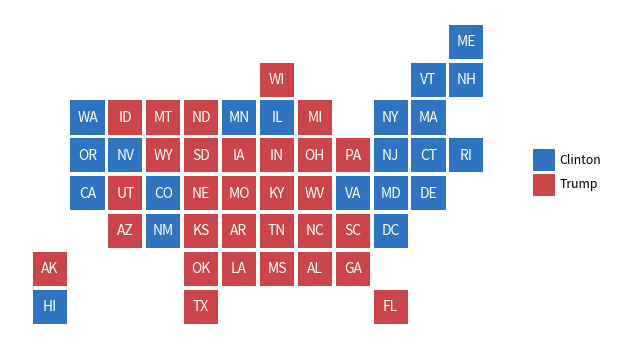

<ggplot: (8756710611285)>

In [28]:
statebins(
    election, state_col='state', value_col='party', text_color='white'
) + scale_fill_manual(
    party_colors,  # defined at Fig. 7.2
    labels=lambda labs: [{'Democratic': 'Clinton', 'Republican': 'Trump'}[x] for x in labs]
) + theme(
    legend_position='right'
)

merged by state names


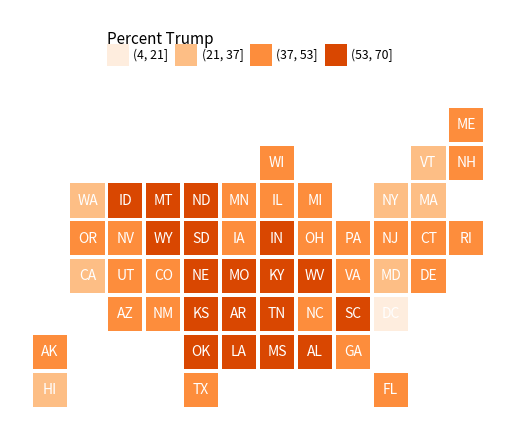

<ggplot: (8756696020089)>

In [29]:
statebins(
    election.assign(pct_trump=lambda d: pd.cut(d['pct_trump'], [4, 21, 37, 53, 70])),
    state_col='state', value_col='pct_trump', text_color='white'
) + scale_fill_brewer(
    palette="Oranges", name='Percent Trump'
) + theme(legend_title=element_text(), legend_position='top')

## Fig. 7.16

NOTE: In the original code `scale_fill_viridis_c(option = "plasma")` means choosing "plasma" color mapping.

In [30]:
opiates = opiates.assign(region=lambda d: d['state'].str.lower())
opiates_map = us_states.merge(opiates, on='region', how='left')

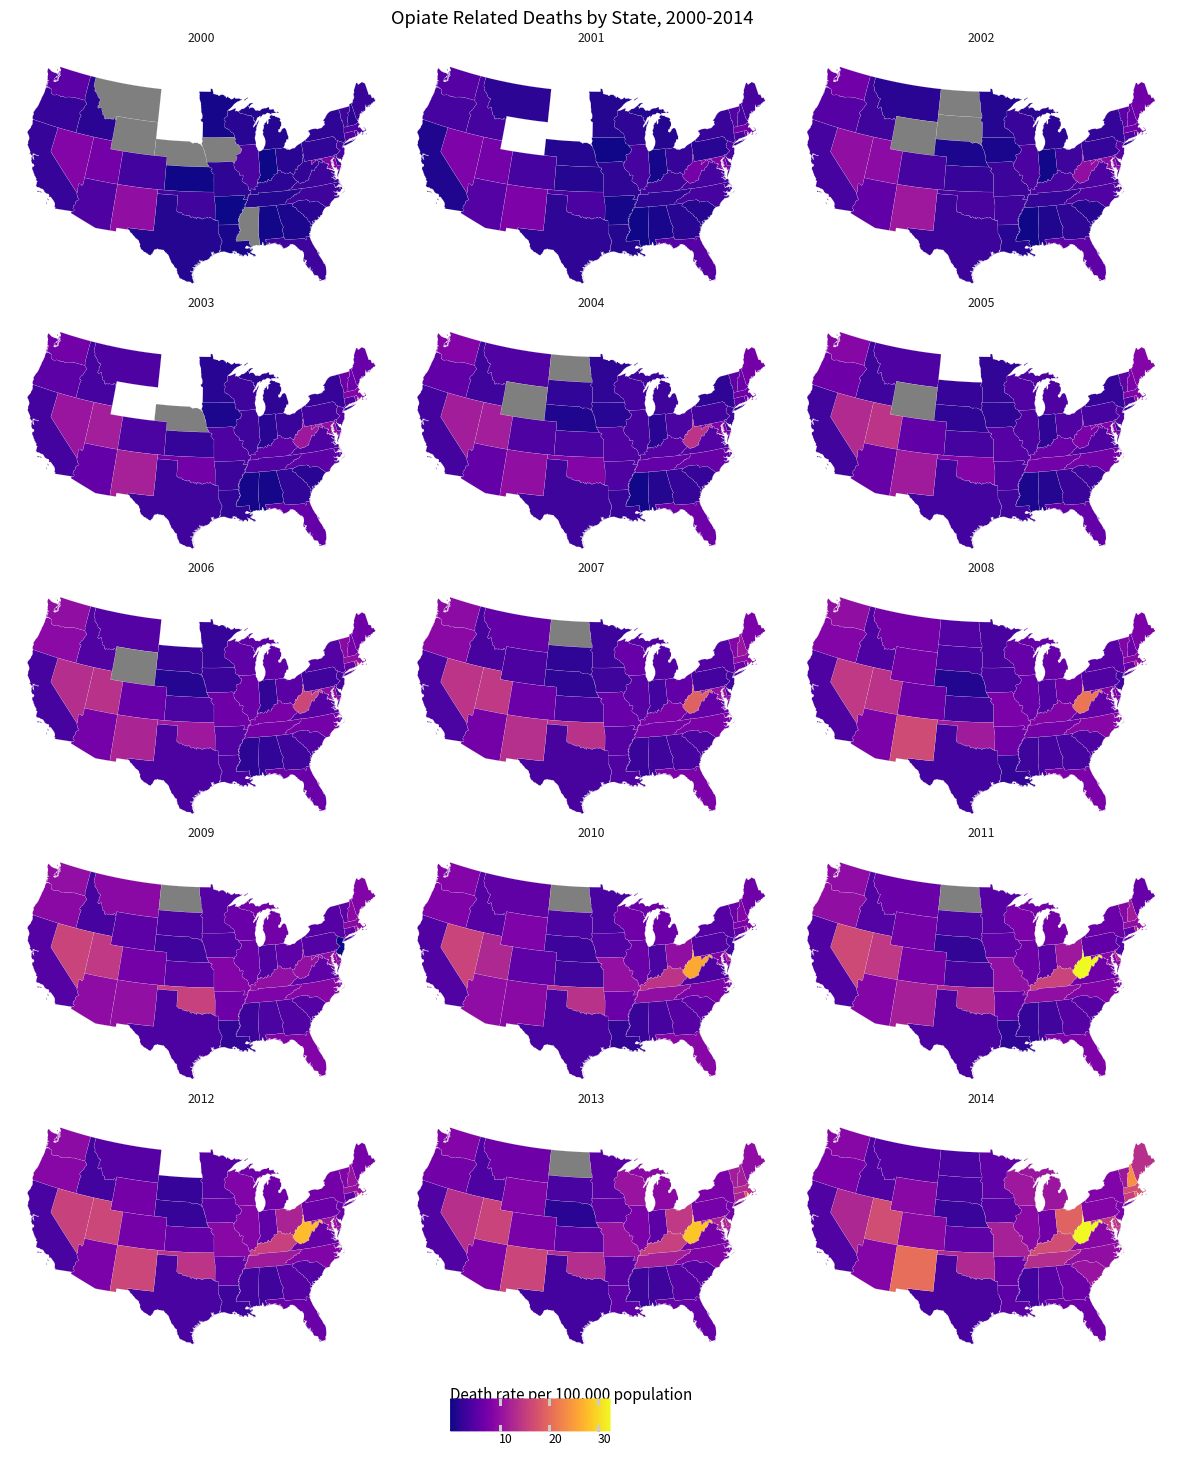

<ggplot: (8756696270442)>

In [31]:
p0 = ggplot(
    opiates_map.loc[lambda d: d['year'] > 1999],
    aes(fill='adjusted')
)

p1 = p0 + geom_map(color=dcolors['gray90'], size=.05)
p2 = p1 + scale_fill_cmap('plasma')

p2 + theme_map_pseudo(
) + facet_wrap('~ year', ncol=3) + theme(
    legend_position="bottom",
    strip_background=element_blank(),
    legend_title=element_text()
) + labs(
    fill="Death rate per 100,000 population ",
    title="Opiate Related Deaths by State, 2000-2014"
) + coord_fixed() + theme(
    figure_size=(15, 10)
)

## Fig. 7.17

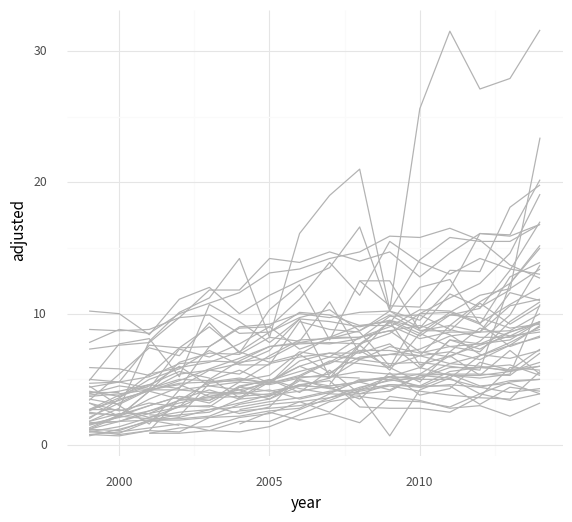

<ggplot: (8756696477025)>

In [32]:
p = ggplot(opiates, aes(x='year', y='adjusted', group='state'))
p + geom_line(color=dcolors['gray70'])

## Fig. 7.18

NOTE 1: In the pandas version, column `division_name`'s missing value is string `"nan"`, so we can't drop the missing values by `.dropna()` or `.isna()`.

NOTE 2: Although **plotnine** currently (v0.8) doesn't support `segment.color` arguments in `geom_text`, `segment.color=NULL` means not filling the text box with any color (transparant). So I just dismissed this argument.

NOTE 3: **plotnine** currently (v0.8) can't use `reorder()` in `facet_wrap()`. The order of facet panels depens on the order of `Categorical`  type (see [here](https://github.com/has2k1/plotnine/issues/60
)). In addition, the data is overwritten at `geom_text`, which takes `opiates` that has pre-converted `division_name`. Finally I defined a new data frame `opiates_ordered` which has oredered `division_name` column at first.

NOTE 4: In this example, `adjust_text` somehow doesn't work properly. So I gave up avoiding of text overlapping.

In [33]:
# determine the order of `division_name`
means_adjusted = opiates.loc[lambda d: d['division_name']!='nan'].groupby(
    'division_name'
)[['adjusted']].mean().sort_values('adjusted', ascending=False)
cat_dname = pd.CategoricalDtype(categories=means_adjusted.index, ordered=True)

opiates_ordered = opiates.loc[
    lambda d: d['division_name']!='nan'
].assign(
    division_name=lambda d: d['division_name'].astype(cat_dname)
)

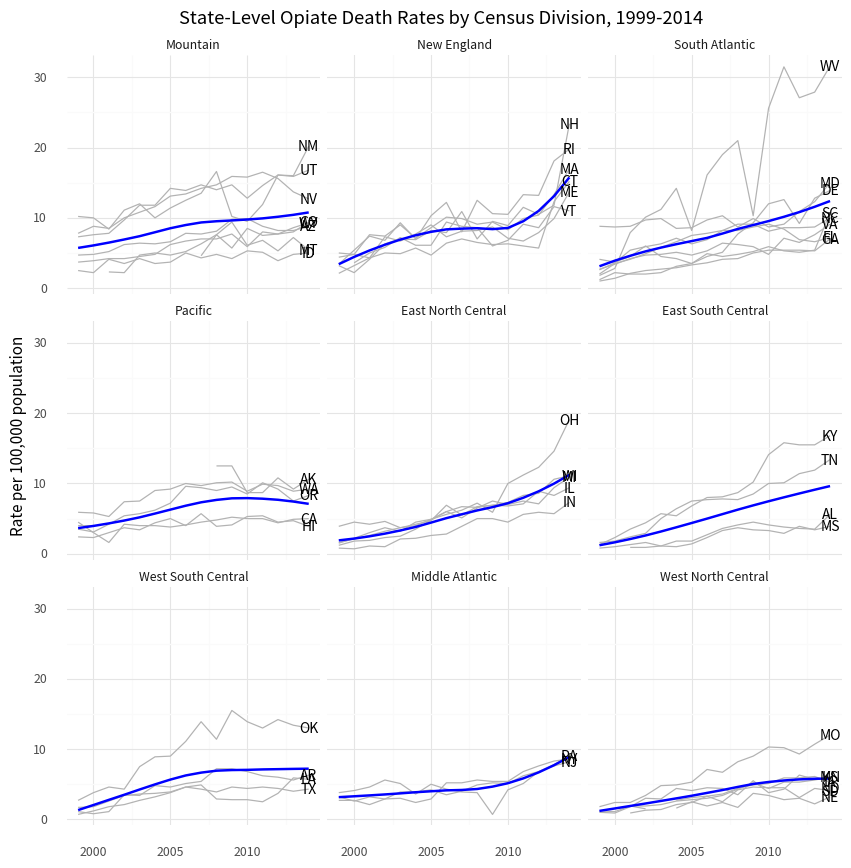

<ggplot: (8756696194699)>

In [34]:
p0 = ggplot(opiates_ordered, aes(x='year', y='adjusted'))

p1 = p0 + geom_line(aes(group='state'), color=dcolors['gray70']) 
p2 = p1 + geom_smooth(aes(group='division_name'), se=False, color='blue')
p3 = p2 + geom_text(
    opiates_ordered.loc[
        lambda d: (d['year']==d['year'].max()) & (d['abbr'] != 'DC')
    ],
    aes(x='year', y='adjusted', label='abbr'), size=10
) + coord_cartesian([opiates['year'].min(),  opiates['year'].max()])
p3 + labs(
    x="",
    y="Rate per 100,000 population",
    title="State-Level Opiate Death Rates by Census Division, 1999-2014"
) + facet_wrap('~division_name', nrow=3) + theme(
    figure_size=(10, 10)
)